In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import random
import zipfile as zf
import cv2
import tensorflow as tf
import pickle

from sklearn.metrics import classification_report,confusion_matrix
from sklearn import metrics
from sklearn.preprocessing import LabelBinarizer,LabelEncoder
from sklearn.model_selection import train_test_split

from keras.models import Sequential,Model
from keras.layers import Conv2D,Dense,Flatten,Dropout,AveragePooling2D,MaxPool2D,Input
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam,RMSprop,SGD
from keras.applications import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils

from imutils import build_montages
from google.colab.patches import cv2_imshow

sns.set()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [2]:
os.getcwd()

'/content'

In [0]:
handle_data = zf.ZipFile(r'/content/data.zip')
handle_data.extractall('/content/Data')
handle_data.close()

handle_clips = zf.ZipFile(r'/content/example_clips.zip')
handle_clips.extractall('/content/Clips')
handle_clips.close()

In [0]:
football_dir = os.listdir('/content/Data/data/football/')
tennis_dir = os.listdir('/content/Data/data/tennis/')
wtlift_dir = os.listdir('/content/Data/data/weight_lifting/')

fp_football = '/content/Data/data/football/'
fp_tennis = '/content/Data/data/tennis/'
fp_wtlift = '/content/Data/data/weight_lifting/'

In [0]:
images = []
labels = []

for i in tennis_dir:
  if i[-3] != 'n' and i[-3] != 'g':
    image = cv2.imread(fp_tennis+i)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224,224))
    images.append(image)
    labels.append('Tennis')
 

for i in football_dir:
  image = cv2.imread(fp_football+i)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image, (224,224))
  images.append(image)
  labels.append('Football')


for i in wtlift_dir:
  if i[-3] != 'g' and i[-4] != 'w':
    image = cv2.imread(fp_wtlift+i)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224,224))
    images.append(image)
    labels.append('Weight_Lifting')



In [7]:
images[0].shape

(224, 224, 3)

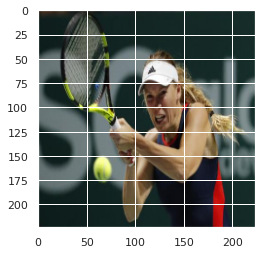

In [8]:
plt.imshow(images[0])

In [0]:
images = np.array(images)
labels = np.array(labels)

In [12]:
images.shape

(2064, 224, 224, 3)

In [13]:
labels.shape

(2064,)

In [0]:
lb = LabelBinarizer()

In [15]:
labels = lb.fit_transform(labels)
labels

array([[0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1]])

In [0]:
#Football - 100
#Tennis - 010
#Wt-Lift- 001

In [0]:
(trainX,testX,trainY,testY) = train_test_split(images,labels,test_size=0.2,stratify=labels,random_state=42)

In [18]:
print(trainX.shape)
print(type(trainX))
print(trainY.shape)
print(type(trainY))
print(testX.shape)
print(type(testX))
print(testY.shape)
print(type(testY))

(1651, 224, 224, 3)
<class 'numpy.ndarray'>
(1651, 3)
<class 'numpy.ndarray'>
(413, 224, 224, 3)
<class 'numpy.ndarray'>
(413, 3)
<class 'numpy.ndarray'>


In [19]:
trainY

array([[0, 0, 1],
       [1, 0, 0],
       [1, 0, 0],
       ...,
       [0, 0, 1],
       [1, 0, 0],
       [1, 0, 0]])

In [0]:
trainAug = ImageDataGenerator(
	rotation_range=30,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [0]:
valAug = ImageDataGenerator()

In [0]:
mean = np.array([123.68, 116.779, 103.939], dtype="float32")
trainAug.mean = mean
valAug.mean = mean

In [0]:
class myCB(tf.keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs={}):
    if(logs.get('val_accuracy')>0.90):
      print('\nReached 90% accuracy')
      self.model.stop_training = True


In [0]:
cb = myCB()

In [25]:
baseModel = ResNet50(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(len(lb.classes_), activation="softmax")(headModel)


model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
	layer.trainable = False

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 1s 0us/step


In [0]:
BS = 32
EPOCHS = 50

opt = SGD(lr=1e-4, momentum=0.9, decay=1e-4 / EPOCHS)

In [0]:
model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])

In [28]:
H = model.fit_generator(
	trainAug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=valAug.flow(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS,callbacks=[cb])

Epoch 1/50
51/51 [==============================] - 33s 649ms/step - loss: 1.3376 - accuracy: 0.3607 - val_loss: 1.1580 - val_accuracy: 0.4609
Epoch 2/50
51/51 [==============================] - 27s 521ms/step - loss: 1.0627 - accuracy: 0.4997 - val_loss: 0.6104 - val_accuracy: 0.6325
Epoch 3/50
51/51 [==============================] - 26s 506ms/step - loss: 0.9295 - accuracy: 0.5664 - val_loss: 0.6548 - val_accuracy: 0.7218
Epoch 4/50
51/51 [==============================] - 26s 504ms/step - loss: 0.7760 - accuracy: 0.6603 - val_loss: 0.6317 - val_accuracy: 0.7822
Epoch 5/50
51/51 [==============================] - 26s 503ms/step - loss: 0.7377 - accuracy: 0.6665 - val_loss: 0.4716 - val_accuracy: 0.8136
Epoch 6/50
51/51 [==============================] - 25s 499ms/step - loss: 0.6626 - accuracy: 0.7307 - val_loss: 0.5229 - val_accuracy: 0.8189
Epoch 7/50
51/51 [==============================] - 25s 496ms/step - loss: 0.6052 - accuracy: 0.7498 - val_loss: 0.4158 - val_accuracy: 0.8399

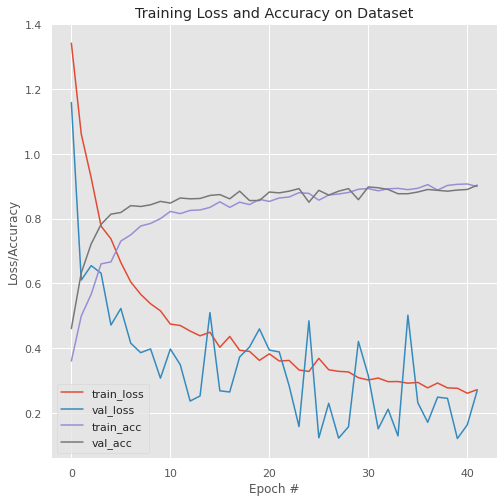

In [29]:
N = 42
plt.style.use("ggplot")
plt.figure(figsize=(8,8))
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [0]:
from keras.models import load_model
from collections import deque

In [0]:
model.save('sports.model')

In [0]:
SIZE=128

In [0]:
mean = np.array([123.68, 116.779, 103.939][::1], dtype="float32")
Q = deque(maxlen=SIZE)

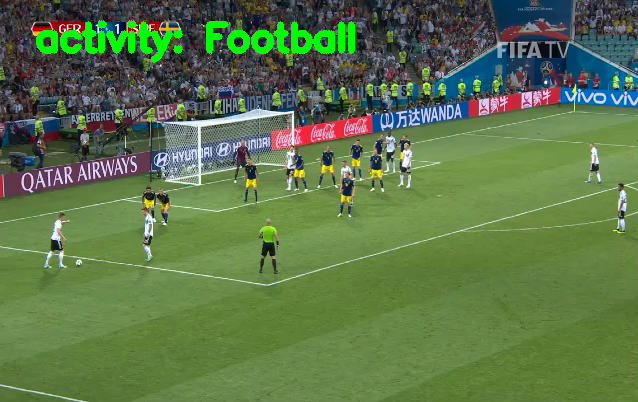

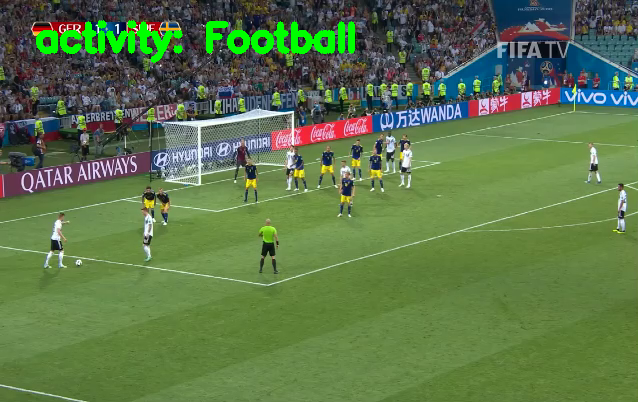

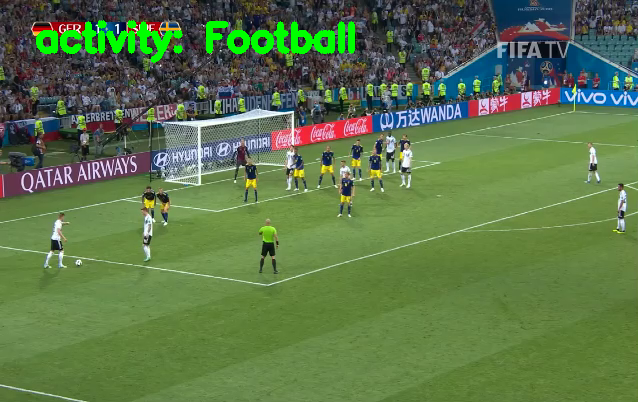

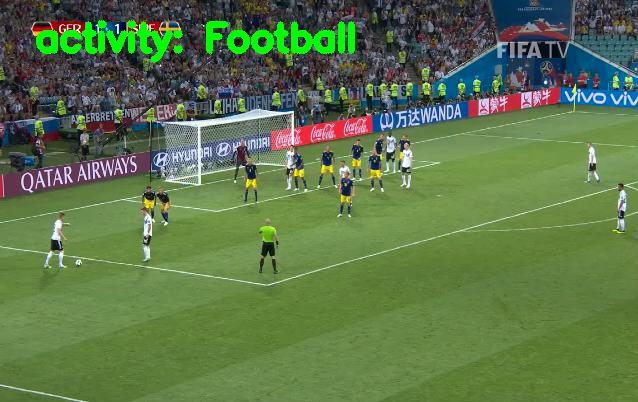

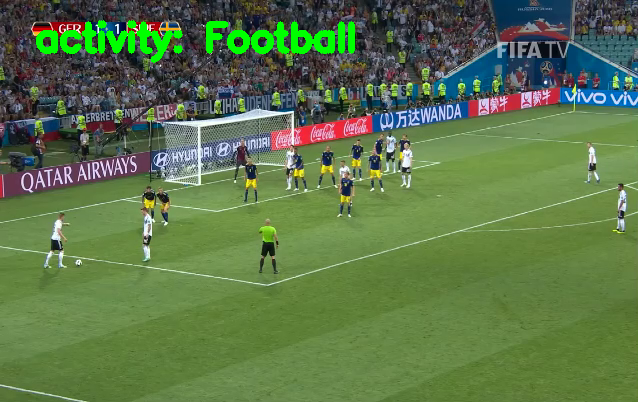

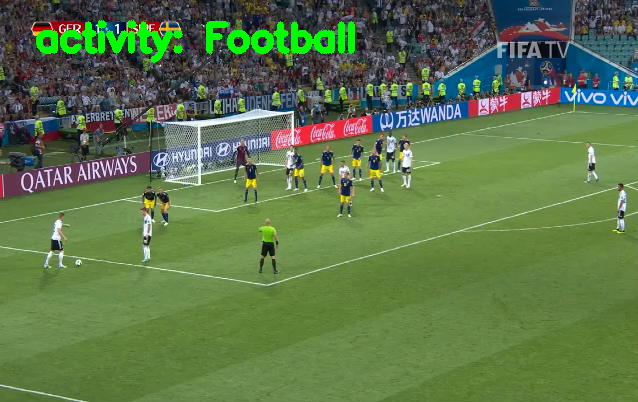

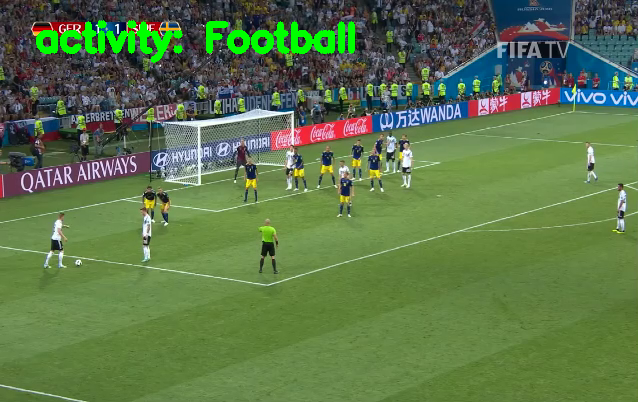

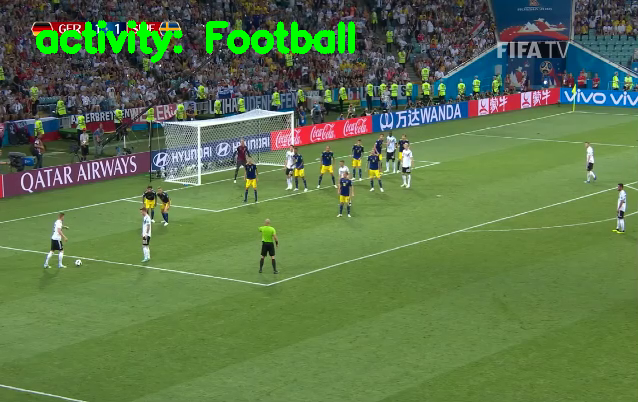

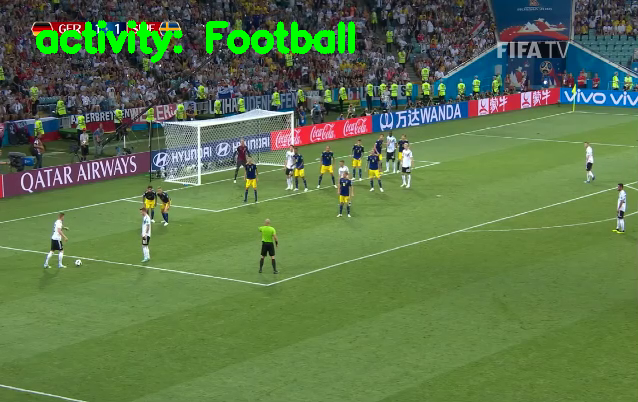

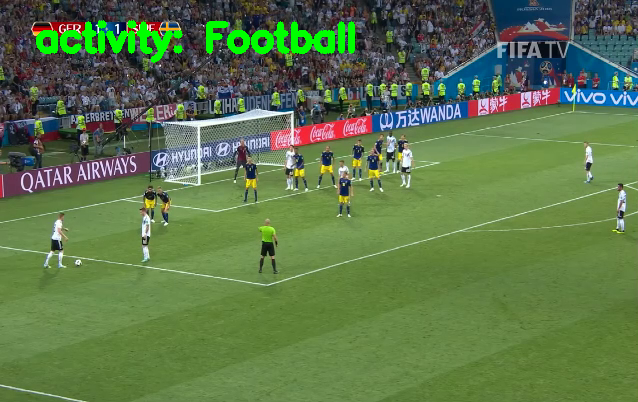

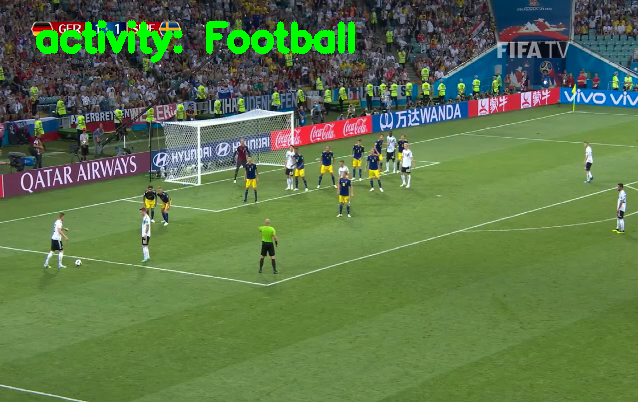

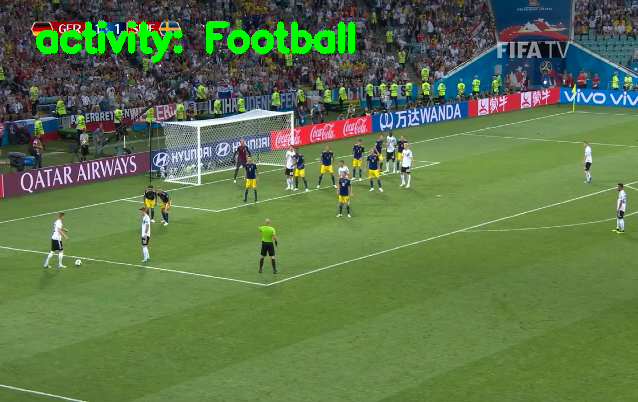

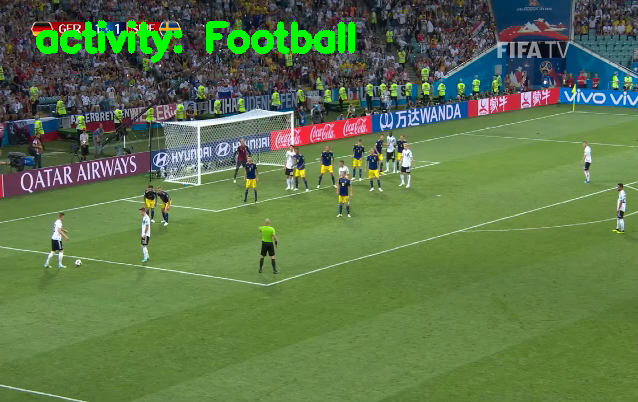

In [0]:
vs = cv2.VideoCapture('/content/Clips/example_clips/soccer.mp4')
writer = None
(W, H) = (None, None)

# loop over frames from the video file stream
while True:
	# read the next frame from the file
	(grabbed, frame) = vs.read()

	# if the frame was not grabbed, then we have reached the end
	# of the stream
	if not grabbed:
		break

	# if the frame dimensions are empty, grab them
	if W is None or H is None:
		(H, W) = frame.shape[:2]

	# clone the output frame, then convert it from BGR to RGB
	# ordering, resize the frame to a fixed 224x224, and then
	# perform mean subtraction
	output = frame.copy()
	frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
	frame = cv2.resize(frame, (224, 224)).astype("float32")
	frame -= mean

	# make predictions on the frame and then update the predictions
	# queue
	preds = model.predict(np.expand_dims(frame, axis=0))[0]
	Q.append(preds)

	# perform prediction averaging over the current history of
	# previous predictions
	results = np.array(Q).mean(axis=0)
	i = np.argmax(results)
	label = lb.classes_[i]

	# draw the activity on the output frame
	text = "activity: {}".format(label)
	cv2.putText(output, text, (35, 50), cv2.FONT_HERSHEY_SIMPLEX,
		1.25, (0, 255, 0), 5)

	# check if the video writer is None
	if writer is None:
		# initialize our video writer
		fourcc = cv2.VideoWriter_fourcc(*"MJPG")
		writer = cv2.VideoWriter('/content/Clips/soccer_output.avi', fourcc, 30,(W, H), True)

	# write the output frame to disk
	writer.write(output)

	# show the output image
	cv2_imshow(output)
	key = cv2.waitKey(1) & 0xFF

	# if the `q` key was pressed, break from the loop
	if key == ord("q"):
		break

# release the file pointers
print("[INFO] cleaning up...")
writer.release()
vs.release()